# Implementation of Diffuision Maps using Random Forest Kernel

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from scipy import misc

## 1 Setup Random Forest Kernel

### 1.1 Load MNIST Dataset

In [6]:
# Load MNIST dataset
(MNIST_X, MNIST_y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [7]:
# Reshaping the array to 4-dims so that it can work with the Keras API
MNIST_X = MNIST_X.reshape(len(MNIST_X),-1)
x_test = x_test.reshape(len(x_test),-1)

# Making sure that the values are float so that we can get decimal points after division
MNIST_X = MNIST_X.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
MNIST_X /= 255
x_test /= 255
print('x_train shape:', MNIST_X.shape)
print('Number of images in x_train', MNIST_X.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 784)
Number of images in x_train 60000
Number of images in x_test 10000


### 1.2 Load IRIS Dataset

In [8]:
from sklearn import datasets

iris = datasets.load_iris()

IRIS_X = iris.data
IRIS_y = iris.target

target_names = iris.target_names

### 1.3 RFK Matrix Using MNIST

In [9]:
from sklearn.ensemble import RandomForestClassifier

def RFK(x_train, y_train, num_trees=100, depth=5): 
    """Creates the random forest kernel matrix using 100 trees with depth 5.
    
    Arguments:
        - x_train: Training data
        - y_train: Training labels
        - num_trees: Determines the number of trees that random forest will make
        - depth: Max depth of each tree
    """
    # Build classifier
    RF = RandomForestClassifier(n_estimators=num_trees, max_depth=depth, random_state=0)
    RF.fit(x_train, y_train)

    # Get the nodes that they end up on
    """
    # Rows = Image index
    # Columns = tree index
    # final_nodes[i, j] = the leaf node that input i landed at for tree j
    """
    final_nodes = RF.apply(x_train)

    
    # TODO Optimize l8r
    num_data = len(x_train)

    num_trees = final_nodes.shape[1]
    K = np.zeros((num_data,num_data))

    # For each tree
    for j in range(100):
        tmp_P = []
        for i in range(num_data):        
            s = np.array([int(final_nodes[i][j] == leaf) for leaf in final_nodes[:, j]])
            tmp_P.append(s)
        K += np.array(tmp_P)

    return K

## 2 Setup Diffusion Map

In [10]:
# Note theres no square in the diffusion distance
def diffusion_dist(i, j):
    """ Computes the diffusion distance between two vectors X_i and X_j.
    
    Arguments:
        i: first vector
        j: second vector
    """
    return np.linalg.norm(i - j)**2

In [69]:
# TODO CONVERT ME
def diffusion_map_RFK(train_x, train_y, m, t=1):
    """ Comptues the diffusion matrix for a given data set using the RFK function. 
    Reduces the dimensionality of each data point to size m.
    
    Arguments:
        train_x: (N, C) matrix of data points. Each point is a row vector.
        train_x: (N, ) column vector of training labels.
        m: New reeduced dimension size of matrix. m <= C.
        alpha: Neighborhood size for RBF kernel
    """
    N, C = train_x.shape
    # Valid dimensionality reduction request
    if (m < 1) or (m > C):
        raise Exception('Bad reduced dimension. Make sure m is with [1, rank(data)] %d > %d' % (m, C))
        
    diffusion_matrix = []
    
    # 1. Define a kernel K    
    kernel_matrix = RFK(train_x, train_y) 
    
    # 2. Create diffusion matrix (P - the row normalized kernel)
    P = kernel_matrix / np.sum(kernel_matrix, axis=1).reshape(-1, 1)
    P = np.linalg.matrix_power(P, t)
        
    # 3. Calculate the eigenvectors of the diffusion matrix.
    eigen_vals, eigen_vecs = np.linalg.eig(P)     
    
    idx = np.argsort(eigen_vals)[::-1]
    eigen_vecs = eigen_vecs[:, idx]
    eigen_vals = eigen_vals[idx]

    #eigen_vals = eigen_vals**t
    
    # 4. Map to the d-dimensional diffusion space at time t, 
    #    using the d dominant eigenvectors and -values as
    for i in range(len(train_x)):
        row = (eigen_vals[i] * eigen_vecs[i , :])
        # Reduce the diffusion matrix to dimension m
        diffusion_matrix.append(row[:m])
        
    return np.array(diffusion_matrix)

In [73]:
DM = diffusion_map_RFK(IRIS_X, IRIS_y, 2, t=1)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


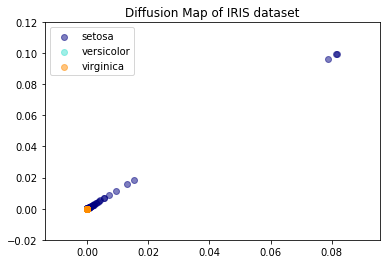

In [81]:
X_r3 = diffusion_map_RFK(IRIS_X, IRIS_y, 2, t=1)

colors = ['navy', 'turquoise', 'darkorange']
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r3[IRIS_y == i, 0], X_r3[IRIS_y == i, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Diffusion Map of IRIS dataset')

plt.show()

In [82]:
DM[0]

array([ 0.08164966+0.j,  0.09961162+0.j])

In [80]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100., kernel='linear')

clf.fit(X_r3, IRIS_y)
sum(clf.predict(X_r3) == IRIS_y)/len(IRIS_y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


0.40000000000000002